# Inverse functions with Grover's algorithm

In this notebook, we will look for antecendents of images by a function,
i.e. given a funcion $f$ and an image $y$, we will search $x$ such that $y = f(x)$.

To do so, we will use Grover's search algorithm.
It is called function inversion because, in the end, what we are doing is computing $f^{-1}$
by searching all $x$ such that $x = f^{-1}(y)$.

The functions we will study in this notebook are:
* NOT: `NOT(x) = (x == 0) ? 1 : 0`
* AND: `AND(x,y) = (x == 1 && y == 1) ? 1 : 0`

In both cases, we will look for the antecedent(s) of 1.

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from math import pi, floor, sqrt

In [2]:
provider = IBMQ.load_account()

## Definition of the quantum circuits of the classical functions

Before being able to use Grover's algorithm, we need to turn those two classical functions to quantum circuits.

### NOT

To implement NOT as a quantum circuit, we will need a circuit of 2 qubits, one for the input (which will not be modified) and one for the output (initialized to |0>).

### AND

To implement AND as a quantum circuit, we will need a circuit of 3 qubits, two for the inputs (which will not be modified) and one for the output (initialized to |0>).

However, the output qubit may not be initialized to |0> and give a different output, but it is not a problem for us.

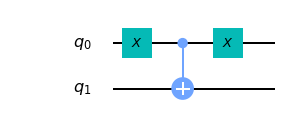

In [3]:
not_circuit = QuantumCircuit(2, name='NOT')
not_circuit.x(0)
not_circuit.cx(0, 1)
not_circuit.x(0)

not_circuit.draw()

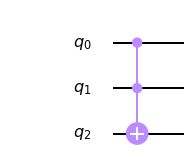

In [4]:
and_circuit = QuantumCircuit(3, name='AND')
and_circuit.ccx(0, 1, 2)

and_circuit.draw()

## Definition of the oracles

We have implemented the functions we want to study as quantum circuits, let us now implement the oracles.

We want to look for antecedent(s) of 1, and both NOT and AND produce the state |1> on their output qubit when the qubit is initialized to |0>.
Actually, with our implementations, if the result of the function is 1, then the output qubit is flipped. This means that if the parameters are the ones we look for then the output qubit is flip. However, for Grover's algorithm, we should turn this bit flip to a phase flip. By chance, $HXH=Z$. So, surrounding the output qubit with Hadamard gates will be enough to create our oracles.

In [5]:
def create_oracle(circuit: QuantumCircuit) -> QuantumCircuit:
    """
    Create an oracle for Grover's algorithm given a circuit that outputs 1
    if what we are looking for is true.
    
    :param circuit: a quantum circuit implementing a function with the last qubit as output qubit.
    """
    n_qubits = circuit.n_qubits
    oracle = QuantumCircuit(n_qubits, name='Uf')
    oracle.h(n_qubits - 1)
    oracle.append(circuit.to_instruction(), range(n_qubits))
    oracle.h(n_qubits - 1)
    return oracle

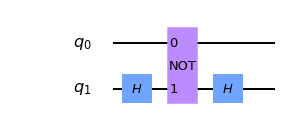

In [6]:
oracle_not = create_oracle(not_circuit)
oracle_not.draw()

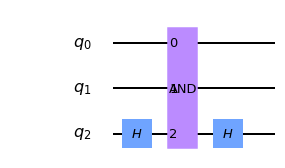

In [7]:
oracle_and = create_oracle(and_circuit)
oracle_and.draw()

## Implement Grover's algorithm

For explainations see the other notebook.

In [8]:
# CCZ
ccz = QuantumCircuit(3, name='CCZ')
ccz.h(2)
ccz.toffoli(0, 1, 2)
ccz.h(2)

# Us
def build_us(n_qubits: int) -> QuantumCircuit:
    """
    Build Us for a circuit with ``n_qubits`` qubits.
    """
    if(n_qubits < 2 or n_qubits > 3):
        raise ValueError("n_qubits must be 2 or 3")
    us = QuantumCircuit(n_qubits, name='Us')
    us.h(range(n_qubits))
    us.x(range(n_qubits))
    if(n_qubits == 2):
        us.cz(0, 1)
    else:
        us.append(ccz.to_instruction(), range(3))
    us.x(range(n_qubits))
    us.h(range(n_qubits))
    return us

# Build the circuit
def build_grover_circuit(oracle: QuantumCircuit) -> QuantumCircuit:
    """
    Function to build a circuit implementing Grover's algorithm given an oracle Uf.
    
    :param oracle: the oracle Uf to put in the circuit
    """
    n_qubits = oracle.n_qubits
    us = build_us(n_qubits)
    circuit = QuantumCircuit(n_qubits, n_qubits)
    circuit.h(range(n_qubits))
    for i in range(floor(pi/4 * sqrt(2**n_qubits))):
        circuit.append(oracle.to_instruction(), range(n_qubits))
        circuit.append(us.to_instruction(), range(n_qubits))
    circuit.measure(range(n_qubits), range(n_qubits))
    return circuit

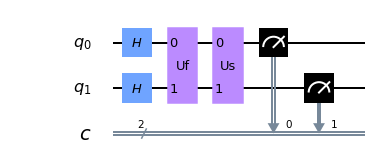

In [9]:
grover_not = build_grover_circuit(oracle_not)
grover_not.draw()

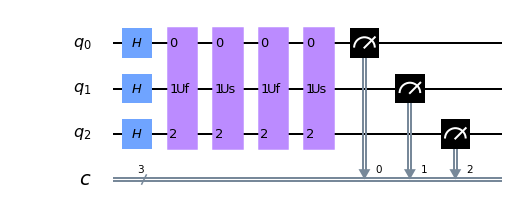

In [10]:
grover_and = build_grover_circuit(oracle_and)
grover_and.draw()

## Simulation

In [11]:
def simulate(circuit):
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, backend=simulator, shots=1024)
    return job.result().get_counts(circuit)

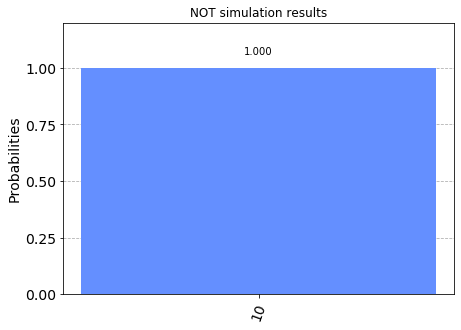

In [12]:
plot_histogram(simulate(grover_not), title="NOT simulation results")

In NOT case, the input is |0x> because q0 is x and q1 is initialized to |0>.
The output is |NOT(x),x> because q0 is still x but q1 is the result of NOT(x).

Here, we can see that the output is |10>, which corresponds to NOT(x)=1 (what we where looking for) and x=0.
Indeed, we can check that `NOT(0)==1`.

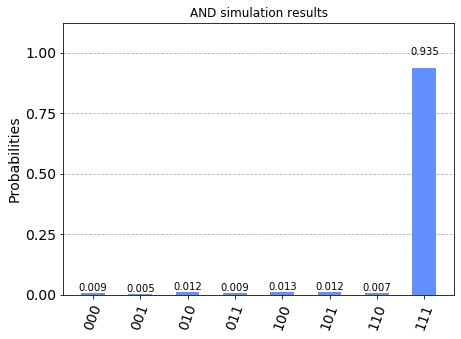

In [13]:
plot_histogram(simulate(grover_and), title="AND simulation results")

Same thing here, the output is |x,y,AND(x,y)>.

The result is |111> (in most cases because Grover's algorithm is not deterministic).
So, the output is AND(x,y)=1 (what we where looking for), x=1 and y=1.
Indeed, `AND(1,1)==1`.

## Run on a real device

We will run our circuits on real devices but we will not mitigate the noise (even if it is possible) because it is not the purpose of this notebook.

In [14]:
device = least_busy(provider.backends(filters=lambda b: not b.configuration().simulator
                                              and b.status().operational
                                              and b.configuration().n_qubits >= 3))
print(device)

ibmq_london


Job Status: job has successfully run


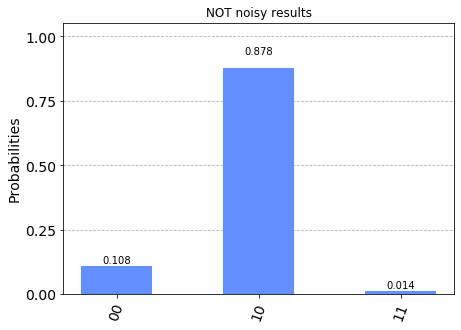

In [15]:
job_not = execute(grover_not, backend=device, shots=1024)
job_monitor(job_not)
counts_not = job_not.result().get_counts()
plot_histogram(counts_not, title="NOT noisy results")

Job Status: job has successfully run


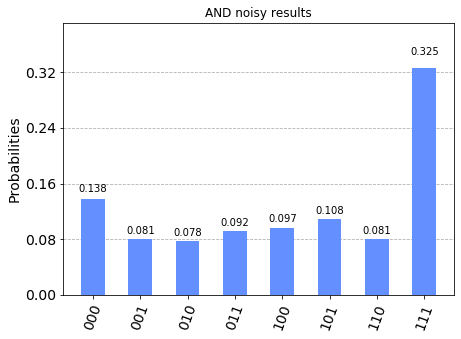

In [16]:
job_and = execute(grover_and, backend=device, shots=1024)
job_monitor(job_and)
counts_and = job_and.result().get_counts()
plot_histogram(counts_and, title="AND noisy results")

## Conclusion

In this notebook, we saw how to use Grover's algorithm to retrieve the antecedent(s) of a function. Even if we tested this method on two straigthforward examples (NOT and AND), it can be used on more complex functions even if the function output is not a boolean because we can always build a boolean function that returns True if the result is the one we are looking for:

```python
def f(x):
    pass # complex computations

def g(x, y):
    return f(x) == y
# Search with Grover's algorithm for which x, g(x, y) is True
```